In [1]:
import stringphylo
import numpy as np
import pandas as pd
import os

from stringphylo.gp import fit_generic_gpmod, fit_string_gpmod

from sklearn.preprocessing import scale

import matplotlib.pyplot as plt

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logging.getLogger("utils").setLevel('INFO')

# Data preparation

The ASV table and phenotypes

In [2]:
# load ASV table and phenotypes
asv_table = pd.read_csv("../data/asv_table.csv").set_index("sample_id")
phenotypes = pd.read_csv("../data/phenotypes.csv").set_index("#SampleID")
common_samples = np.intersect1d(asv_table.index, phenotypes.index)

logger.info(f"ASV table shape: {asv_table.shape}, phenotypes shape: {phenotypes.shape}")
logger.info(f"{common_samples.shape[0]} samples with phenotype and ASV counts")

asv_table = asv_table.loc[common_samples,:]
phenotypes = phenotypes.loc[common_samples,:]

assert np.all(np.isnan(asv_table).sum()==0)
assert np.all(np.isnan(phenotypes).sum()==0)
assert asv_table.shape[0]==phenotypes.shape[0]
assert asv_table.index.equals(phenotypes.index)

2023-01-09 19:15:14 INFO     ASV table shape: (394, 525), phenotypes shape: (388, 1)
2023-01-09 19:15:14 INFO     388 samples with phenotype and ASV counts


# Computing string kernels

Given an $n \times p$ OTU table, the $S$ matrix is a $p \times p$ matrix of pairwise OTUs (or ASV) similarities. This is then used to compute the $n \times n$ matrix $K$ using $K = X S X^T$ (see Ish-Horowicz and Filippi, 2002).

First, we load the representative sequences from their fasta files using skbio. We control the OTU names using the index of the Series.

In [4]:
import skbio
repr_sequences = skbio.io.read(
    "../data/ravel_refseq.fasta",
    format='fasta')
repr_sequences = [x for x in repr_sequences]
repr_sequences = [x.values.tobytes().decode("utf-8")  for x in repr_sequences]
repr_sequences = pd.Series(repr_sequences, index=asv_table.columns)
repr_sequences

OTU_0      AAGGGCCGTATCTCAGTCCCCTTGTGGCCGTCCACCCTCTCAGGCC...
OTU_1      AAGGGCCGTATCTCAGTCCCCTTGTGGCCGTCCACCCTCTCAGGCC...
OTU_10     AAGGGCCGTATCTCAGTCCCCTTGTGGCCGTCCACCCTCTCAGGCC...
OTU_100    AAGGGCCGTATCTCAGTCCCCTTGTGGCCGTCCACCCTCTCAGGCC...
OTU_101    AAGGGCCGTATCTCAGTCCCCTTGTGGCCGTCCACCCTCTCAGGCC...
                                 ...                        
OTU_95     TTGGGCCGTGTCTCAGTCCCAATGTGGCCGATCAGTCTCTCAACTC...
OTU_96     TTGGGCCGTGTCTCAGTCCCAATGTGGCCGATCAGTCTCTCAACTC...
OTU_97     TTGGGCCGTGTCTCAGTCCCAATGTGGCCGATCAGTCTCTCAACTC...
OTU_98     TTTGGGCCGTGTCTCAGTCCCAATGTGGCCGATCAGTCTCTCAACT...
OTU_99     TTTGGGCCGTGTCTCAGTCCCAATGTGGCCGATCAGTCTCTCAACT...
Length: 525, dtype: object

Next, we compute the $S$ matrices for the kernels we want to use - a spectrum kernel with $k$-mer length from 2 to 30. Note that the canididate kernels are stored in a DataFrame with a column named `Q`, which contains the OTU-wise similarities. All other columns are treated as hyperparameter values.

In [5]:
# tell rpy2 where to find the right R packages
from rpy2.robjects.packages import importr
base = importr('base')
base._libPaths()[0] = '~/anaconda3/envs/tf2-gpu/lib/R/library'

from stringphylo.kebab_wraps import spectrum_kernel, gappy_pair_kernel, mismatch_kernel, compute_Smat

# compute the S matrices for spectrum kernels with k from 2,30
Smats = [compute_Smat(spectrum_kernel(k=k), repr_sequences) for k in range(2,30)]
kernel_df = pd.DataFrame({'k' : range(2,30)})
kernel_df['Q'] = Smats

We can see the effect of the $k$-mer length by visualising the result for $k=2$ and $k=30$ - when $k=30$ the $S$ matrix has more zero values for distantly-related taxa. I.e. the only non-zero blocks correspond to closely-related taxa.

Text(0.5, 1.0, 'S matrix for Spectrum kernel with k=30')

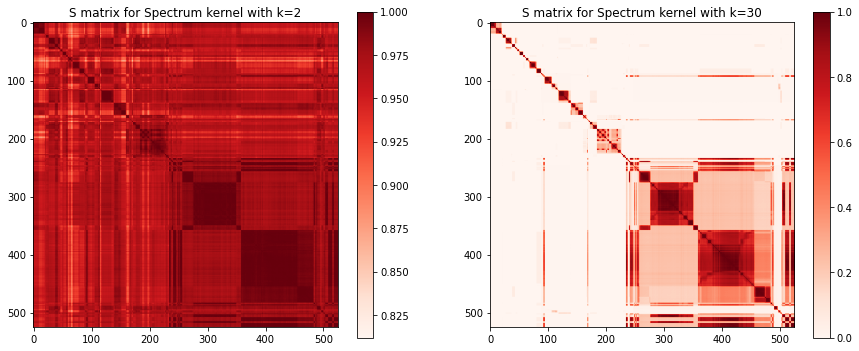

In [41]:
import matplotlib.pyplot as plt

# visualise the kernel
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# k=2
im = axes[0].imshow(Smats[0], cmap="Reds")
plt.colorbar(im, ax=axes[0])
axes[0].set_title("S matrix for Spectrum kernel with k=2")

# k=30
im = axes[1].imshow(Smats[27], cmap="Reds")
plt.colorbar(im, ax=axes[1])
axes[1].set_title("S matrix for Spectrum kernel with k=30")

# Fitting the GP models

We fit GP models with two different kernels - a spectrum kernel with $k$-mer length from 2 to 30, and an RBF kernel. For the string kernel we can select the value of $k$ that maximises the log-marginal likelihood.

The `fit_string_gpmod` will perform this cross-validation over the kernels in each row of `kernel_df`. 

In [42]:
from gpflow.kernels import RBF
from skbio.stats.composition import clr, closure, multiplicative_replacement

# apply the CLR transform before computing the kernels
def clr_transform(x):
    return clr(closure(multiplicative_replacement(x)))

# GP fit
NOISE_VAR_STARTING_GUESS = 1.0
SIGNAL_VAR_STARTING_GUESS = 1.0
OPT = True

# The GP model sees the CLR-transformed counts and scaled phenotypes
X = clr_transform(asv_table.to_numpy().astype(float))
y = scale(phenotypes.Var.to_numpy().astype(float))

gp_rbf, _, _ = fit_generic_gpmod(
    X, y,
    lambda: RBF(variance=SIGNAL_VAR_STARTING_GUESS),
    NOISE_VAR_STARTING_GUESS,
    OPT)

# fit_string_gpmod will select the best value of k given a DataFrame of kernels with 
# different hyperparameters
gp_string, string_lmls, best_hparams = fit_string_gpmod(
    X, y,
    SIGNAL_VAR_STARTING_GUESS,
    NOISE_VAR_STARTING_GUESS,
    OPT,
    kernel_df
)

# Log-marginal likelihood

In a real application we would do a more systematic evaluation of the GP fits, for example using cross-validation.

For this simple example we just check the log-marginal likelihoods for the spectrum kernel with different values of $k$-mer length. The fit improves as the value of $k$ is increased and then plateaus. Any $k$-mer length gives a larger log-marginal likelihood than the RBF kernel (the red horizontal line).

Text(0, 0.5, 'log-marginal likelihood')

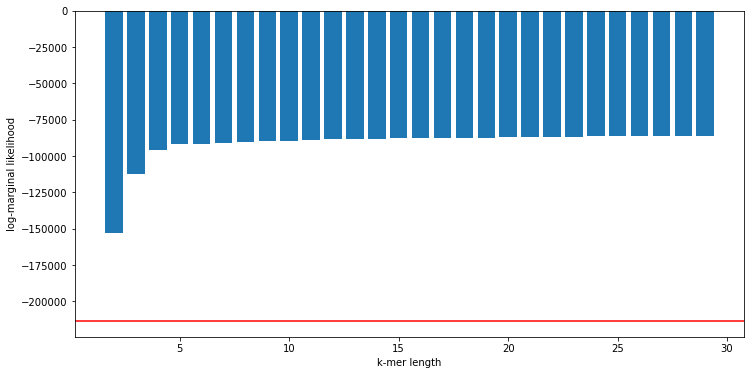

In [43]:
# plot the log-marginal likelhioods
string_lmls_plot = string_lmls.copy()
string_lmls_plot.k = string_lmls_plot.k.astype(int)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x=string_lmls_plot.k, height=string_lmls_plot.lml)
ax.axhline(gp_rbf.log_posterior_density().numpy(), c="red")
ax.set_xlabel("k-mer length")
ax.set_ylabel("log-marginal likelihood")